In [1]:
import time
from tqdm import tqdm
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate

import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import Audio

In [2]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cpu - cpu


In [ ]:
# Cambie la ruta donde se encuentre su dataset
DATASET = 'Emotions/input/'

In [3]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk(DATASET):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [4]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10)

,speech,label
4291,Emotions/input/Fearful\03-02-06-01-02-02-01.wav,fearful.wav
4815,Emotions/input/Fearful\1030_ITS_FEA_XX.wav,fearful.wav
1907,Emotions/input/Angry\OAF_third_angry.wav,angry.wav
10818,Emotions/input/Sad\1030_DFA_SAD_XX.wav,sad.wav
3917,Emotions/input/Disgusted\YAF_limb_disgust.wav,disgusted.wav
12055,Emotions/input/Sad\YAF_gin_sad.wav,sad.wav
8540,Emotions/input/Neutral\1010_WSI_NEU_XX.wav,neutral.wav
8665,Emotions/input/Neutral\1021_IWL_NEU_XX.wav,neutral.wav
5069,Emotions/input/Fearful\1048_IWW_FEA_XX.wav,fearful.wav
11057,Emotions/input/Sad\1047_IEO_SAD_HI.wav,sad.wav


In [5]:
# se remueve el archivo .ds_store
data = data[data.label.apply(lambda x: x != '.ds_store')]

In [6]:
# Labelencoder para convertir las clases a etiquetas númericas
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'label'.
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [8]:
#Debido al volumen de los datos y la disparidad entre clases se decide tomar 300 registros po clase
nMax = 300 
data2 = data.groupby('label').apply(lambda x: x.sample(n=min(nMax, len(x))))
print(data2['label'].value_counts())

0    300
2    300
4    300
6    300
1    300
3    300
5    300
Name: label, dtype: int64


In [9]:
# Adicionalmente a la cantidad de registros, se eligen 4 clases para el estudio debido al alto costo computacional
data2 = data2[data2.label.apply(lambda x: x in (0,1,2,3)) ]

In [11]:
# se renombra la variable speech por path
data2.rename(columns={'speech':'path'}, inplace=True)

In [13]:
# se crea los conjuntos de entrenamiento y test (80 % para el entrnamiento y lo demás para el test)
train_df = data2.sample(frac=0.8)
test_df = data2.drop(train_df.index)

In [14]:
# se renombra la variable label por labels
test_df2=test_df.rename(columns = {'label':'labels'})

In [16]:
# Se muestra el primer registro.
import IPython.display as ipd
id = 0
print(train_df.iloc[id])
ipd.Audio(data=train_df.iloc[id]["path"], autoplay=True, rate=16000)

path     Emotions/input/Angry\1024_IEO_ANG_MD.wav
label                                           0
Name: (0, 698), dtype: object


In [17]:
# Mediante la clase Wav2Vec2FeatureExtractor se extraen las caracteristicas de los audios del modelo preentrenado HuBERT, además se fija el periodo de muestro en 16kHz
from transformers import Wav2Vec2FeatureExtractor
from datasets import Dataset
import librosa

def map_to_array(example):
    speech, _ = librosa.load(example["path"], sr=16000, mono=True)
    example["speech"] = speech
    return example

train_data = Dataset.from_pandas(train_df).map(map_to_array)
test_data = Dataset.from_pandas(test_df).map(map_to_array)

feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-large-superb-er")

train_encodings = feature_extractor(list(train_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")
test_encodings = feature_extractor(list(test_data["speech"]), sampling_rate=16000, padding=True, return_tensors="pt")

Parameter 'function'=<function map_to_array at 0x0000017989FD6700> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/960 [00:00<?, ?ex/s]

  0%|          | 0/240 [00:00<?, ?ex/s]

In [18]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        pattern = {0:0, 1:1, 2:2, 3:3}
        self.labels = [pattern[x] for x in labels]

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    

train_dataset = EmotionDataset(train_encodings, list(train_data["label"]))
test_dataset = EmotionDataset(test_encodings, list(test_data["label"]))

In [19]:
from transformers import HubertForSequenceClassification
from torch.optim import AdamW

# Carga del modelo
model = HubertForSequenceClassification.from_pretrained("superb/hubert-large-superb-er")
model.to(device)

# Se elige y carga el optimizador con tasa de aprendizaje de 1e-5
optim = AdamW(model.parameters(), lr=1e-5)


In [20]:
# Función de predicción
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions


In [21]:
# Entrenamiento

from torch.utils.data import DataLoader

# Se fija el número de epocas para el entrenamiento
epoch = 20


model.train()

train_loss = list()
train_accuracies = list()
for epoch_i in range(epoch):
    print('Epoch %s/%s' % (epoch_i + 1, epoch))
    time.sleep(0.3)

   
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # Se realizan las predicciones
        predictions = predict(outputs)

        # accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # se muestra el progreso en una barra y las métricas loss, accuracy
        pbar.set_postfix({
            'Loss': '{:.3f}'.format(loss.item()),
            'Accuracy': '{:.3f}'.format(accuracy)
        })
        
        # Se registran las perdidas para cada batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # Se registran las perdidas y accuracy para cada epoca
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/20


100%|██████████| 480/480 [1:03:33<00:00,  7.94s/it, Loss=0.052, Accuracy=0.330]


Epoch 2/20


100%|██████████| 480/480 [1:02:04<00:00,  7.76s/it, Loss=0.140, Accuracy=0.443]


Epoch 3/20


100%|██████████| 480/480 [1:02:08<00:00,  7.77s/it, Loss=1.674, Accuracy=0.544]


Epoch 4/20


100%|██████████| 480/480 [1:02:13<00:00,  7.78s/it, Loss=0.875, Accuracy=0.620]


Epoch 5/20


100%|██████████| 480/480 [1:02:03<00:00,  7.76s/it, Loss=0.439, Accuracy=0.657]


Epoch 6/20


100%|██████████| 480/480 [1:01:31<00:00,  7.69s/it, Loss=0.300, Accuracy=0.710]


Epoch 7/20


100%|██████████| 480/480 [1:01:10<00:00,  7.65s/it, Loss=0.290, Accuracy=0.757]


Epoch 8/20


100%|██████████| 480/480 [1:01:12<00:00,  7.65s/it, Loss=0.650, Accuracy=0.769]


Epoch 9/20


100%|██████████| 480/480 [1:01:09<00:00,  7.64s/it, Loss=0.172, Accuracy=0.782]


Epoch 10/20


100%|██████████| 480/480 [1:01:17<00:00,  7.66s/it, Loss=1.537, Accuracy=0.828]


Epoch 11/20


100%|██████████| 480/480 [1:01:18<00:00,  7.66s/it, Loss=0.402, Accuracy=0.846]


Epoch 12/20


100%|██████████| 480/480 [1:01:04<00:00,  7.63s/it, Loss=0.170, Accuracy=0.852]


Epoch 13/20


100%|██████████| 480/480 [1:01:04<00:00,  7.63s/it, Loss=0.147, Accuracy=0.877]


Epoch 14/20


100%|██████████| 480/480 [1:01:22<00:00,  7.67s/it, Loss=0.180, Accuracy=0.886]


Epoch 15/20


100%|██████████| 480/480 [1:01:23<00:00,  7.67s/it, Loss=0.108, Accuracy=0.884]


Epoch 16/20


100%|██████████| 480/480 [1:02:15<00:00,  7.78s/it, Loss=0.002, Accuracy=0.911]


Epoch 17/20


100%|██████████| 480/480 [1:05:11<00:00,  8.15s/it, Loss=0.372, Accuracy=0.896]


Epoch 18/20


100%|██████████| 480/480 [1:04:17<00:00,  8.04s/it, Loss=0.019, Accuracy=0.902]


Epoch 19/20


100%|██████████| 480/480 [1:03:28<00:00,  7.93s/it, Loss=0.021, Accuracy=0.915]


Epoch 20/20


100%|██████████| 480/480 [1:03:33<00:00,  7.94s/it, Loss=0.036, Accuracy=0.921]


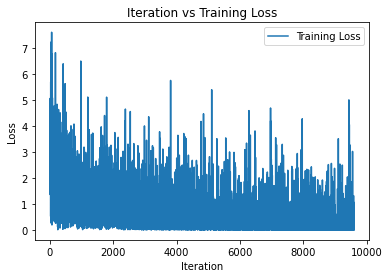

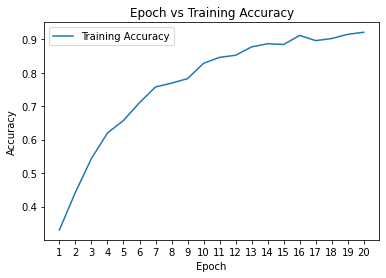

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
acc_X = np.arange(len(train_accuracies))+1                          
plt.plot(acc_X, train_accuracies,"-", label="Training Accuracy")
plt.xticks(acc_X)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()


In [23]:
# Testing
from torch.utils.data import DataLoader


test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = {"labels":list(), "predictions":list()}
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_values'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record["labels"] += labels.cpu().numpy().tolist()
        record["predictions"] += predictions.cpu().numpy().tolist()
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 240/240 [05:08<00:00,  1.29s/it, loss=0.016, accuracy=0.921] 


The final accuracy on the test dataset: 92.0833%


In [24]:
test_df2['emotion']= test_df2.path.apply(lambda x : x.split('/')[2])

In [25]:
# Se convierten los registros del test en objetos del DataFrame de pandas
from pandas.core.frame import DataFrame

df_record = DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

def get_emotion(label_id):
    return model.config.id2label[label_id]
    
df_record["Ground Truth"] = df_record.apply(lambda x: get_emotion(x["Ground Truth"]), axis=1)
df_record["Model Prediction"] = df_record.apply(lambda x: get_emotion(x["Model Prediction"]), axis=1)

df = pd.concat([test_df2.reset_index(), df_record["Model Prediction"]], axis=1)
df["emotion"] = df.apply(lambda x: x["emotion"][:3], axis=1)


# Se muestan las predicciones incorrectas
df[df["emotion"]!=df["Model Prediction"]]


,label,level_1,path,labels,emotion,Model Prediction
0,0,1642,Emotions/input/Angry\1091_MTI_ANG_XX.wav,0,Ang,neu
1,0,1449,Emotions/input/Angry\1077_TSI_ANG_XX.wav,0,Ang,neu
2,0,1054,Emotions/input/Angry\1049_MTI_ANG_XX.wav,0,Ang,neu
3,0,522,Emotions/input/Angry\1011_IWW_ANG_XX.wav,0,Ang,sad
4,0,1189,Emotions/input/Angry\1059_IOM_ANG_XX.wav,0,Ang,neu
...,...,...,...,...,...,...
235,3,7473,Emotions/input/Happy\1074_IEO_HAP_HI.wav,3,Hap,neu
236,3,7227,Emotions/input/Happy\1056_IWL_HAP_XX.wav,3,Hap,sad
237,3,7422,Emotions/input/Happy\1070_ITS_HAP_XX.wav,3,Hap,sad
238,3,6743,Emotions/input/Happy\1021_WSI_HAP_XX.wav,3,Hap,sad


In [26]:
df['Model Prediction'].value_counts()

neu    70
ang    60
hap    57
sad    53
Name: Model Prediction, dtype: int64

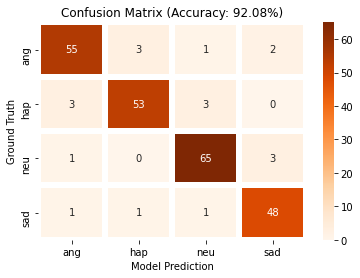

In [27]:
# Confusion Matrix
import seaborn as sns

crosstab = pd.crosstab(df_record["Ground Truth"],df_record["Model Prediction"])
sns.heatmap(crosstab, cmap='Oranges', annot=True, fmt='g', linewidths=5)
accuracy = df_record["Ground Truth"].eq(df_record["Model Prediction"]).sum() / len(df_record["Ground Truth"])
plt.title("Confusion Matrix (Accuracy: %s%%)" % round(accuracy*100,2))
plt.show()